In [1]:
# All the imports you will need in the whole lab
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

from skimage.exposure import histogram
from skimage.morphology import skeletonize
from skimage import io
from skimage.filters import threshold_otsu, laplace
from skimage.color import rgb2gray
from skimage.util import invert
from skimage.segmentation import flood, flood_fill

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import csv
import math


In [2]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    plt.bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')

In [3]:
def read_data(file_name):
    data = []
    with open(file_name, newline='') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=' ', quotechar='|')
        for row in spamreader:
            data.append([float(element) for element in row[0].split(',')])
    return data

In [4]:
def read_test_data():
    test_data = read_data('validating_data.csv')

    test_data_true = []
    with open('./true_validating_data.csv', newline='') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=' ', quotechar='|')
        for row in spamreader:
            test_data_true.append(float(row[0]))
            
    return test_data, test_data_true

In [5]:
def diacritic_segmentation(image):
    img = np.where(image > 0, 0, 1)
    horizontal_projection = np.sum(img, axis = 1)
    # got certain line
    baseline_location_index = horizontal_projection.argmax()
    
    diacritic_image = np.copy(image)
    previous_val = -1
    current_val = diacritic_image[baseline_location_index,:].argmin()
    
    while previous_val != current_val:
        diacritic_image = flood_fill(diacritic_image, (baseline_location_index, current_val), 255)
        previous_val = current_val
        current_val = diacritic_image[baseline_location_index,:].argmin()

    image_text = image - diacritic_image
    image_text = np.where(image_text > 0, 0, 1)
    
    # show_images([image, diacritic_image, image_text])

    return diacritic_image.astype(np.uint8), image_text.astype(np.uint8)

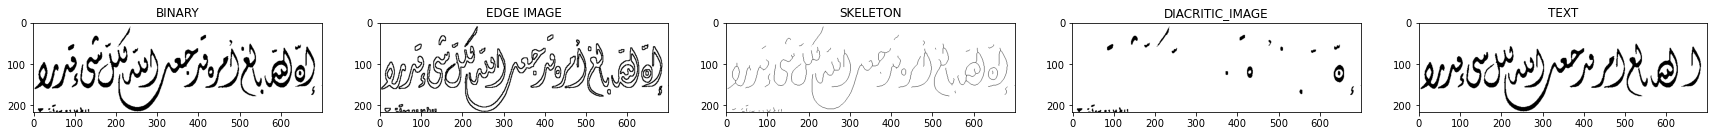

In [6]:
def preprocessing_image(img):
    '''
    DESCRIPTION:
    Preprocess an image.
        1. Grayscale
        2. OTSU Threshold
        3. Binarization
        4. Checking image binary is 0 or 255
        5. Laplacian filter
    
    RETURN:
    binary_image, edge_image, skeleton_image, diacritic_image, text_image
    '''
    grayscale_image = rgb2gray(img)
    if grayscale_image.max() <= 1:
        grayscale_image = (grayscale_image * 255)
    grayscale_image = grayscale_image.astype(np.uint8)
    
    global_threshold = threshold_otsu(grayscale_image)
    binary_image = np.where(grayscale_image > global_threshold, 255, 0)
    # binary_image = grayscale_image > global_threshold
    
    image_histogram = np.asarray(histogram(binary_image, nbins=256))
    if image_histogram.argmax() <= 150:
        binary_image = 255 - binary_image
    binary_image = binary_image.astype(np.uint8)
    
    edge_image = cv2.convertScaleAbs(cv2.Laplacian(binary_image, cv2.CV_16S, ksize=3))
    edge_image = 255 - edge_image
    edge_image[edge_image == 255] = 1
    
    inverted_image = invert(binary_image)
    inverted_image[inverted_image == 255] = 1
    skeleton_image = skeletonize(inverted_image, method='zhang')
    skeleton_image = invert(skeleton_image)
    skeleton_image = skeleton_image.astype(np.uint8)
    
    diacritic_image, text_image = diacritic_segmentation(binary_image)
    diacritic_image = np.where(diacritic_image > 0, 1, 0)
    diacritic_image = diacritic_image.astype(np.uint8)
    show_images([binary_image, edge_image, skeleton_image, diacritic_image, text_image], ['BINARY', 'EDGE IMAGE', 'SKELETON', 'DIACRITIC_IMAGE', 'TEXT'])
    
    return binary_image, edge_image, skeleton_image, diacritic_image, text_image

img = io.imread("..\\..\\data\\raw\\1\\0001.jpg")
# img = io.imread("..\\..\\data\\raw\\2\\0191.jpg")
x = preprocessing_image(img)

In [7]:
def hvsl_features(edge_image):
    thresh = cv2.threshold(edge_image, 0, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Detect horizontal lines
    horizontal_image = np.ones(edge_image.shape)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
    detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # for c in cnts:
    cv2.drawContours(horizontal_image, cnts, -1, (0, 0, 0), 2)
        
    horizontal_image = np.where(horizontal_image > 0, 0, 1)
    horizontal_lines = np.sum(horizontal_image, axis=1)
    h_unique, h_count = np.unique(horizontal_lines, return_counts=True)
    h_dict = dict(zip(h_unique, h_count))
    frequency_horizontal_lines = edge_image.shape[0] - h_dict[0] if h_dict[0] != edge_image.shape[0] else 0
    
    # Detect vertical lines
    vertical_image = np.ones(edge_image.shape)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,10))
    detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # for c in cnts:
    cv2.drawContours(vertical_image, cnts, -1, (0, 0, 0), 2)
        
    vertical_image = np.where(vertical_image > 0, 0, 1)
    vertical_lines = np.sum(vertical_image, axis=0)
    v_unique, v_count = np.unique(vertical_lines, return_counts=True)
    v_dict = dict(zip(v_unique, v_count))
    frequency_vertical_lines = edge_image.shape[1] - v_dict[0] if v_dict[0] != edge_image.shape[1] else 0
    
    inverted_img = np.where(edge_image > 0, 0, 1)
    
    # show_images([edge_image, inverted_img])
    
    sum_frequencies = frequency_horizontal_lines + frequency_vertical_lines
    number_pixels = np.sum(np.sum(inverted_img, axis=0))
    ratio = (number_pixels - sum_frequencies) / number_pixels
    
    # print(frequency_horizontal_lines, frequency_vertical_lines, ratio)
    return frequency_horizontal_lines, frequency_vertical_lines, ratio

# img = io.imread("..\\..\\data\\raw\\1\\0001.jpg")
# img = io.imread("..\\..\\data\\raw\\2\\0191.jpg")
# img = io.imread("..\\..\\data\\raw\\3\\0381.jpg")
# img = io.imread("..\\..\\data\\raw\\4\\0561.jpg")
# img = io.imread("..\\..\\data\\raw\\5\\746.jpg")
# img = io.imread("..\\..\\data\\raw\\6\\0941.jpg")
# img = io.imread("..\\..\\data\\raw\\7\\1121.jpg")
# img = io.imread("..\\..\\data\\raw\\8\\1306.jpg")
# img = io.imread("..\\..\\data\\raw\\9\\1496.jpg")
# x = preprocessing_image(img)
# hvsl_features(x[1])

In [8]:
def sobel_angle(image):
    _unique, _count = np.unique(image, return_counts=True)
    image_dict = dict(zip(_unique, _count))
    
    out_x = cv2.Sobel(image, cv2.CV_16S, 1, 0)
    out_y = cv2.Sobel(image, cv2.CV_16S, 0, 1)
    
    out_x = cv2.convertScaleAbs(out_x)
    out_y = cv2.convertScaleAbs(out_y)

    dir = np.arctan2(out_y, out_x)
    dir = np.multiply(dir, 180/np.pi)
    
    dir_unique, dir_count = np.unique(dir, return_counts=True)
    
    angle = np.sum(dir_unique * dir_count) / (np.sum(dir_count) - 2 * dir_count[0] + image_dict[1])
    return np.radians(angle)
     

def text_orientation_features(skeleton_image, edge_image):
    return sobel_angle(skeleton_image), sobel_angle(edge_image)
    
# img = io.imread("..\\..\\data\\raw\\1\\0001.jpg")
# img = io.imread("..\\..\\data\\raw\\2\\0191.jpg")
# img = io.imread("..\\..\\data\\raw\\3\\0381.jpg")
# img = io.imread("..\\..\\data\\raw\\4\\0561.jpg")
# img = io.imread("..\\..\\data\\raw\\5\\746.jpg")
# img = io.imread("..\\..\\data\\raw\\6\\0941.jpg")
# img = io.imread("..\\..\\data\\raw\\7\\1121.jpg")
# img = io.imread("..\\..\\data\\raw\\8\\1306.jpg")
# img = io.imread("..\\..\\data\\raw\\9\\1496.jpg")
# x = preprocessing_image(img)
# text_orientation_features(x[2], x[1])

In [9]:
def lvl_features(skeleton_image):
    # print(skeleton_image.shape)
    thresh = cv2.threshold(skeleton_image, 0, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Detect vertical lines
    vertical_image = np.ones(skeleton_image.shape)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,10))
    detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    cv2.drawContours(vertical_image, cnts, -1, (0, 0, 0))
    
    # show_images([vertical_image, skeleton_image])

    vertical_image = np.where(vertical_image > 0, 0, 1)
    vertical_lines = np.sum(vertical_image, axis=0)
    v_unique, v_count = np.unique(vertical_lines, return_counts=True)
    v_dict = dict(zip(v_unique, v_count))
    
    perimeter=[]
    for cnt in cnts[1:]:
        # perimeter.append(cv2.arcLength(cnt,False))
        x,y,w,h = cv2.boundingRect(cnt)
        perimeter.append(h)
    perimeter = np.asarray(perimeter)
    
    maximum_height = perimeter.max() if len(perimeter) != 0 else 0
    
    frequency_vertical_lines = skeleton_image.shape[1] - v_dict[0] if v_dict[0] != skeleton_image.shape[1] else 0
    
    inverted_img = np.where(skeleton_image > 0, 0, 1)
    inverted_lines = np.sum(inverted_img, axis=1)
    text_locations = np.argwhere(inverted_lines > 0)
    text_height = text_locations.max() - text_locations.min()

    ratio = (text_height - maximum_height) / text_height
    variance = np.mean(vertical_lines)
    
    return text_height, frequency_vertical_lines, maximum_height, ratio, variance
    
# img = io.imread("..\\..\\data\\raw\\1\\0001.jpg")
# img = io.imread("..\\..\\data\\raw\\2\\0191.jpg")
# img = io.imread("..\\..\\data\\raw\\3\\0381.jpg")
# img = io.imread("..\\..\\data\\raw\\4\\0561.jpg")
# img = io.imread("..\\..\\data\\raw\\5\\746.jpg")
# img = io.imread("..\\..\\data\\raw\\6\\0941.jpg")
# img = io.imread("..\\..\\data\\raw\\7\\1121.jpg")
# img = io.imread("..\\..\\data\\raw\\8\\1306.jpg")
# img = io.imread("..\\..\\data\\raw\\9\\1496.jpg")
# x = preprocessing_image(img)
# lvl_features(x[2])

In [10]:
def tth_features(skeleton_image, edge_image):
    # show_images([skeleton_image, edge_image, skeleton_image + edge_image])
    pass
    
# img = io.imread("..\\..\\data\\raw\\9\\1496.jpg")
# x = preprocessing_image(img)
# tth_features(x[2], x[1])

In [11]:
def sp_features(diacritic_image):
    thuluth_mohakik_sp_img = io.imread(".\\special_diacritics.jpg")
    
    thuluth_mohakik_sp_gs = rgb2gray(thuluth_mohakik_sp_img)
    if thuluth_mohakik_sp_gs.max() <= 1:
        thuluth_mohakik_sp_gs = (thuluth_mohakik_sp_gs * 255)
    thuluth_mohakik_sp_gs = thuluth_mohakik_sp_gs.astype(np.uint8)
    
    global_threshold = threshold_otsu(thuluth_mohakik_sp_gs)
    thuluth_mohakik_sp_bin_img = np.where(thuluth_mohakik_sp_gs > global_threshold, 1, 0)
    
    # print(np.unique(diacritic_image))
    # print(np.unique(thuluth_mohakik_sp_bin_img))
    
    # show_images([thuluth_mohakik_sp_bin_img])
    
    thuluth_mohakik_sp_bin_img = thuluth_mohakik_sp_bin_img.astype(np.uint8)
    d2 = cv2.matchShapes(diacritic_image, thuluth_mohakik_sp_bin_img, cv2.CONTOURS_MATCH_I3, 0)
    
    return d2

# img = io.imread("..\\..\\data\\raw\\1\\0001.jpg")
# img = io.imread("..\\..\\data\\raw\\2\\0191.jpg")
# img = io.imread("..\\..\\data\\raw\\3\\0381.jpg")
# img = io.imread("..\\..\\data\\raw\\4\\0561.jpg")
# img = io.imread("..\\..\\data\\raw\\5\\746.jpg")
# img = io.imread("..\\..\\data\\raw\\6\\0941.jpg")
# img = io.imread("..\\..\\data\\raw\\7\\1121.jpg")
# img = io.imread("..\\..\\data\\raw\\8\\1306.jpg")
# img = io.imread("..\\..\\data\\raw\\9\\1496.jpg")
# x = preprocessing_image(img)
# sp_features(x[3])

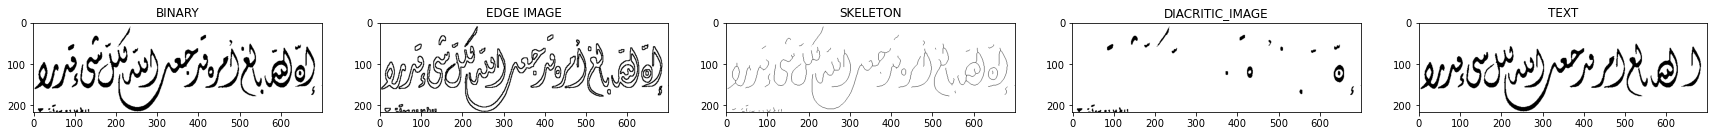

-0.8984183939029252

In [12]:
def wor_features(text_image):
    img = np.where(text_image > 0, 0, 1)
    horizontal_projection = np.sum(img, axis = 1)
    baseline_location_index = horizontal_projection.argmax()
    img = np.copy(text_image)
    previous_val = -1
    current_val = text_image[baseline_location_index,:].argmin()
    
    angles = []
    
    while previous_val != current_val:
        word = flood_fill(text_image, (baseline_location_index, current_val), 255)
        img = flood_fill(img, (baseline_location_index, current_val), 255)
        previous_val = current_val
        current_val = img[baseline_location_index,:].argmin()
        # ------------------------------------------------
        word = np.where(word > 1, 1, 0)
        word = word.astype(np.uint8)
        # ------------------------------------------------
        thresh = cv2.threshold(word, 1, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]

        rows,cols = word.shape[:2]
        [vx,vy,x,y] = cv2.fitLine(cnts[0], cv2.DIST_L2,0,0.01,0.01)
        lefty = int((-x*vy/vx) + y)
        righty = int(((cols-x)*vy/vx)+y)
        # cv2.line(word,(cols-1,righty),(0,lefty),1,2)
        # ------------------------------------------------
        angles.append(np.arctan2(righty - lefty, cols-1 - 0))

        # show_images([word, img, text_image])
        
    angles = np.asarray(angles)
    return angles.mean()

img = io.imread("..\\..\\data\\raw\\1\\0001.jpg")
# img = io.imread("..\\..\\data\\raw\\2\\0191.jpg")
# img = io.imread("..\\..\\data\\raw\\3\\0381.jpg")
# img = io.imread("..\\..\\data\\raw\\4\\0561.jpg")
# img = io.imread("..\\..\\data\\raw\\5\\746.jpg")
# img = io.imread("..\\..\\data\\raw\\6\\0941.jpg")
# img = io.imread("..\\..\\data\\raw\\7\\1121.jpg")
# img = io.imread("..\\..\\data\\raw\\8\\1306.jpg")
# img = io.imread("..\\..\\data\\raw\\9\\1496.jpg")
x = preprocessing_image(img)
wor_features(x[4])

In [13]:
def hpp_features(text_image, window=50):  
    invert_img = np.where(text_image > 0, 0, 1)   
    invert_img = invert_img.astype(np.uint8)
    
    proj = np.sum(invert_img, axis=1)
    proj = proj / proj.sum()
    max_height = text_image.shape[0]
    center = proj.argmax()

    if center - window < 0 and center + window > max_height:
        # BOTH
        # print("BOTH")
        return np.concatenate((np.zeros(window - center), proj, np.zeros(center + window - max_height)))
    elif center - window < 0 and center + window <= max_height:
        # LEFT
        # print("LEFT")
        return np.concatenate((np.zeros(window - center), proj[:center + window]))
    elif center - window >= 0 and center + window > max_height:
        # RIGHT
        # print("RIGHT")
        return np.concatenate((proj[center - window:], np.zeros(center + window - max_height)))
    else:
        # NONE
        # print("NONE")
        return proj[center - window:center + window]

# img = io.imread("..\\..\\data\\raw\\1\\0001.jpg")
# img = io.imread("..\\..\\data\\raw\\2\\0191.jpg")
# img = io.imread("..\\..\\data\\raw\\9\\1496.jpg")
# x = preprocessing_image(img)
# hpp = hpp_features(x[4], 50)

In [14]:
def extract_features(processed_images):
    '''
    DESCRIPTION:
    Calculating feature vector of an image
    
    INPUT:
    binary_image, edge_image, skeleton_image, diacritic_image, text_image
    
    RETURN:
    Array of features 1-D
    '''
    image_features = []
    
    frequency_horizontal_lines, frequency_vertical_lines, ratio = hvsl_features(processed_images[1])
    image_features.append(frequency_horizontal_lines)
    image_features.append(frequency_vertical_lines)
    image_features.append(ratio)
    
    skeleton_direction, edge_direction = text_orientation_features(processed_images[2], processed_images[1])
    image_features.append(skeleton_direction)
    image_features.append(edge_direction)
    
    text_height, frequency_vertical_lines_2, maximum_height, ratio_2, variance = lvl_features(processed_images[2])
    image_features.append(text_height)
    image_features.append(frequency_vertical_lines_2)
    image_features.append(maximum_height)
    image_features.append(ratio_2)
    image_features.append(variance)
    
    distance = sp_features(processed_images[3])
    image_features.append(distance)
    
    angles = wor_features(processed_images[4])
    image_features.append(angles)
    
    image_features = np.asarray(image_features)
    
    histogram_hpp = hpp_features(processed_images[4])
    image_features = np.concatenate((image_features, histogram_hpp))
    
    return image_features

In [15]:
def features_training_validating(base_directory, training_percent):
    '''
    DESCRIPTION:
    Get array of images at specific directory. Directory is divied into M-sections. 
    Each section is divided in N-fonts. Then preprocess, extract features
    
    RETURN:
    Array of N-fonts of arrays of features/image
    [
        Font_X[
            FeatureImg1[...]
            FeatureImg2[...]
            FeatureImg3[...]
            ...
        ]
    ]
    '''
    
    training_features = [[] for x in range(0,9)]
    validating_features = [[] for x in range(0,9)]
    true_validation = [[] for x in range(0,9)]
    features = [[] for x in range(0,9)]
    for folder_num in range(1, 10):
        folder_path = base_directory + "\\" + str(folder_num)
        filenames = os.listdir(folder_path)
        
        for fn in filenames:
            path = os.path.join(folder_path, fn)
            img = io.imread(path)
            preprocessed_image = preprocessing_image(img)
            image_features = extract_features(preprocessed_image)
            features[folder_num - 1].append(image_features)
            
        features[folder_num - 1] = np.asarray(features[folder_num - 1])
        n_training = round(features[folder_num - 1].shape[0] * training_percent)
        training_features[folder_num - 1] = features[folder_num - 1][:n_training]
        validating_features[folder_num - 1] = features[folder_num - 1][n_training:]
        true_validation[folder_num - 1] = np.full((features[folder_num - 1][n_training:].shape[0], 1), folder_num)
        
    return np.asarray(training_features), np.asarray(validating_features), np.asarray(true_validation)

In [16]:
base_directory = "..\\..\\data\\raw"

In [364]:
# (9,(percentage, [features]))
training_features, validating_features, true_validation = features_training_validating(base_directory, 0.8)

C:\Users\omar_\AppData\Local\Temp/ipykernel_17928/2810286816.py:14: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  grayscale_image = rgb2gray(img)
C:\Users\omar_\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [365]:
open("training_data.csv","w").close()
for class_idx, class_features in enumerate(training_features):
    true_class = np.full((class_features.shape[0], 1), class_idx + 1)
    with open('training_data.csv', 'a') as csvfile:
        np.savetxt(csvfile, np.concatenate((true_class, np.asarray(class_features)), axis=1), delimiter=",")

In [366]:
open("validating_data.csv","w").close()
open("true_validating_data.csv","w").close()
for class_idx, class_features in enumerate(validating_features):
    with open('validating_data.csv', 'a') as csvfile:
        np.savetxt(csvfile, class_features, delimiter=",")
    
    with open('true_validating_data.csv', 'a') as csvfile:
        np.savetxt(csvfile, true_validation[class_idx], delimiter=",")

In [17]:
font_names = ['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']

In [18]:
training_data = np.asarray(read_data('training_data.csv'))
test_data, test_data_true = read_test_data()

In [19]:
nClasses = 9
M = len(training_data)
N = len(test_data[0])
K = len(test_data)

In [20]:
X = np.asarray(training_data)[:, 1:N + 1]
X_Test = np.asarray(test_data)
Y = np.asarray(training_data)[:, 0:1]

In [21]:
# parameters = {'kernel':['poly'], 'C':[1,2,3,4,5], 'gamma': 
#               [0.01,0.02,0.03,0.04,0.05,0.10,0.2,0.3,0.4,0.5]}

# clf = svm.SVC()
# grid = GridSearchCV(clf, parameters, n_jobs=-1, verbose=3)
# grid.fit(X, Y.ravel())

In [22]:
# print(grid.best_estimator_)

In [69]:
clf = MLPClassifier(random_state=0, max_iter=90000, hidden_layer_sizes=(2,), 
                    solver='lbfgs', alpha=0.1, learning_rate='constant',
                    activation='identity')
clf.fit(X, Y.ravel())
prediction_classes = clf.predict(X_Test)
numpy_predicted_classes = np.array(prediction_classes)
numpy_true_test_data = np.array(test_data_true)

accuracy = sum(numpy_true_test_data == numpy_predicted_classes) / K
print('Accuracy = ' + str(round(accuracy,4) * 100) + '%')

Accuracy = 69.14%


C:\Users\omar_\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [57]:
clf = svm.SVC(kernel='rbf', C=400000)
clf.fit(X, Y.ravel())
prediction_classes = clf.predict(X_Test)
numpy_predicted_classes = np.array(prediction_classes)
numpy_true_test_data = np.array(test_data_true)

accuracy = sum(numpy_true_test_data == numpy_predicted_classes) / K
print('Accuracy = ' + str(round(accuracy,4) * 100) + '%')

Accuracy = 74.48%


In [35]:
print(classification_report(numpy_true_test_data, numpy_predicted_classes, target_names=font_names))
# print((Y.reshape(1, -1)[0] - 1).shape)
# print((numpy_predicted_classes - 1).shape)

              precision    recall  f1-score   support

      diwani       0.94      0.76      0.84        38
       naskh       0.78      1.00      0.87        38
       parsi       0.50      0.33      0.40        36
       rekaa       0.53      0.62      0.57        37
     thuluth       0.82      0.59      0.69        39
    maghribi       0.43      0.44      0.44        36
        kufi       0.67      0.70      0.68        37
     mohakek       0.61      0.79      0.69        38
 Squar-kufic       0.92      0.89      0.91        38

    accuracy                           0.69       337
   macro avg       0.69      0.68      0.68       337
weighted avg       0.69      0.69      0.68       337



In [144]:
# HVSL
# print(X[:, [0,1,2]].shape)
below_1 = np.asarray([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9])
param_gamma = np.concatenate((below_1, np.asarray([i for i in range(1, 2)])))
parameters = {'kernel':['rbf'], 'C': np.asarray([i for i in range(4, 10)]),
              'gamma': param_gamma}

clf_hvsl = svm.SVC(random_state=0, probability=True)
grid_hvsl = GridSearchCV(clf_hvsl, parameters)
grid_hvsl.fit(X[:, [0,1,2]], Y.ravel())
print("HVSL:", grid_hvsl.best_estimator_)

HVSL: SVC(C=7, gamma=0.001, probability=True, random_state=0)


In [148]:
# ToS
# print(X[:, [3]].shape)
below_1 = np.asarray([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9])
param_gamma = np.concatenate((below_1, np.asarray([i for i in range(1, 2)])))
parameters = {'kernel':['rbf'], 'C': np.asarray([i for i in range(1, 5)]),
              'gamma': param_gamma}

clf_tos = svm.SVC(random_state=0, probability=True)
grid_tos = GridSearchCV(clf_tos, parameters)
grid_tos.fit(X[:, [3]], Y.ravel())
print("TOS:", grid_tos.best_estimator_)

TOS: SVC(C=4, gamma=0.8, probability=True, random_state=0)


In [149]:
# ToE
# print(X[:, [4]].shape)
below_1 = np.asarray([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9])
param_gamma = np.concatenate((below_1, np.asarray([i for i in range(1, 2)])))
parameters = {'kernel':['rbf'], 'C': np.asarray([i for i in range(1, 5)]),
              'gamma': param_gamma}

clf_toe = svm.SVC(random_state=0, probability=True)
grid_toe = GridSearchCV(clf_toe, parameters)
grid_toe.fit(X[:, [4]], Y.ravel())
print("TOE:", grid_toe.best_estimator_)

TOE: SVC(C=4, gamma=0.9, probability=True, random_state=0)


In [150]:
# LVL
# print(X[:, [5,6,7,8,9]].shape)
below_1 = np.asarray([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9])
param_gamma = np.concatenate((below_1, np.asarray([i for i in range(1, 2)])))
parameters = {'kernel':['rbf'], 'C': np.asarray([i for i in range(1, 5)]),
              'gamma': param_gamma}

clf_lvl = svm.SVC(random_state=0, probability=True)
grid_lvl = GridSearchCV(clf_lvl, parameters)
grid_lvl.fit(X[:, [5,6,7,8,9]], Y.ravel())
print("LVL:", grid_lvl.best_estimator_)

LVL: SVC(C=3, gamma=0.01, probability=True, random_state=0)


In [151]:
# SP
# print(X[:, [10]].shape)
below_1 = np.asarray([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9])
param_gamma = np.concatenate((below_1, np.asarray([i for i in range(1, 2)])))
parameters = {'kernel':['rbf'], 'C': np.asarray([i for i in range(1, 5)]),
              'gamma': param_gamma}

clf_sp = svm.SVC(random_state=0, probability=True)
grid_sp = GridSearchCV(clf_sp, parameters)
grid_sp.fit(X[:, [10]], Y.ravel())
print("SP:", grid_sp.best_estimator_)

SP: SVC(C=4, gamma=1.0, probability=True, random_state=0)


In [152]:
# WOr
# print(X[:, [11]].shape)
below_1 = np.asarray([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9])
param_gamma = np.concatenate((below_1, np.asarray([i for i in range(1, 2)])))
parameters = {'kernel':['rbf'], 'C': np.asarray([i for i in range(1, 5)]),
              'gamma': param_gamma}

clf_wor = svm.SVC(random_state=0, probability=True)
grid_wor = GridSearchCV(clf_wor, parameters)
grid_wor.fit(X[:, [11]], Y.ravel())
print("WOR:", grid_wor.best_estimator_)

WOR: SVC(C=4, gamma=0.3, probability=True, random_state=0)


In [153]:
# HPP
# print(X[:, [12]].shape)
below_1 = np.asarray([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9])
param_gamma = np.concatenate((below_1, np.asarray([i for i in range(1, 2)])))
parameters = {'kernel':['rbf'], 'C': np.asarray([i for i in range(1, 5)]),
              'gamma': param_gamma}

clf_hpp = svm.SVC(random_state=0, probability=True)
grid_hpp = GridSearchCV(clf_hpp, parameters)
grid_hpp.fit(X[:, 12:], Y.ravel())
print("HPP:", grid_hpp.best_estimator_)

HPP: SVC(C=4, gamma=1.0, probability=True, random_state=0)


In [165]:
# clf_hvsl = svm.SVC(C=7, gamma=0.001, random_state=0, probability=True)
# clf_tos = svm.SVC(C=4, gamma=0.8, random_state=0, probability=True)
# clf_toe = svm.SVC(C=4, gamma=0.9, random_state=0, probability=True)
# clf_lvl = svm.SVC(C=3, gamma=0.01, random_state=0, probability=True)
# clf_sp = svm.SVC(C=4, gamma=1.0, random_state=0, probability=True)
# clf_wor = svm.SVC(C=4, gamma=0.3, random_state=0, probability=True)
# clf_hpp = svm.SVC(C=4, gamma=1.0, random_state=0, probability=True)
clf_hvsl = svm.SVC(random_state=0, probability=True)
clf_tos = svm.SVC(random_state=0, probability=True)
clf_toe = svm.SVC(random_state=0, probability=True)
clf_lvl = svm.SVC(random_state=0, probability=True)
clf_sp = svm.SVC(random_state=0, probability=True)
clf_wor = svm.SVC(random_state=0, probability=True)
clf_hpp = svm.SVC(random_state=0, probability=True)

In [166]:
clf_hvsl.fit(X[:, [0,1,2]], Y.ravel())
clf_tos.fit(X[:, [3]], Y.ravel())
clf_toe.fit(X[:, [4]], Y.ravel())
clf_lvl.fit(X[:, [5,6,7,8,9]], Y.ravel())
clf_sp.fit(X[:, [10]], Y.ravel())
clf_wor.fit(X[:, [11]], Y.ravel())
clf_hpp.fit(X[:, 12:], Y.ravel())

SVC(probability=True, random_state=0)

In [167]:
hvsl_prob = clf_hvsl.predict_proba(X_Test[:, [0,1,2]])
tos_prob = clf_tos.predict_proba(X_Test[:, [3]])
toe_prob = clf_toe.predict_proba(X_Test[:, [4]])
lvl_prob = clf_lvl.predict_proba(X_Test[:, [5, 6, 7, 8, 9]])
sp_prob = clf_sp.predict_proba(X_Test[:, [10]])
wor_prob = clf_wor.predict_proba(X_Test[:, [11]])
hpp_prob = clf_hpp.predict_proba(X_Test[:, 12:])

In [168]:
total_prob = hvsl_prob + tos_prob + toe_prob + lvl_prob + sp_prob + wor_prob + hpp_prob
total_prob /= np.sum(total_prob, axis=1).reshape(total_prob.shape[0], 1)
print(total_prob.shape)
print(np.sum(total_prob, axis=1).reshape(total_prob.shape[0], 1).shape)

(337, 9)
(337, 1)


In [169]:
numpy_predicted_classes = np.argmax(total_prob, axis=1) + 1
numpy_true_test_data = np.asarray(test_data_true)

accuracy = sum(numpy_true_test_data == numpy_predicted_classes) / K
print('Accuracy = ' + str(round(accuracy,4) * 100) + '%')

Accuracy = 64.99000000000001%
